In [1]:
# --- Import Libraries
import copy
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers, losses, optimizers
from sklearn import random_projection
from sklearn.metrics import accuracy_score

from op import *
from utils import *
from metrics import *
from data import Dataset

**Notes:** 
* https://link.springer.com/article/10.1007/s10044-018-0697-0
* https://keras.io/examples/vision/grad_cam/

In [2]:
#--- Autoselect GPU
from jarvis.utils.general import gpus
gpus.autoselect()

[ 2021-04-28 15:11:55 ] CUDA_VISIBLE_DEVICES automatically set to: 1           


In [3]:
# --- Model Blocks
conv = lambda x, features, dr=1, name=None : layers.Conv1D(filters=features, kernel_size=1, strides=1, dilation_rate=dr, padding='same', name=name)(x)
elu  = lambda x: layers.ELU()(x)
norm = lambda x: layers.BatchNormalization()(x)
mlp  = lambda x, features, dr=1: elu(norm((conv(x, features, dr))))

# --- Model Architecture
def encoder(x, features):
    for f in features:
        x = mlp(x, f)
    return x

def decoder(x, features):
    features = features[::-1]
    for f in features:
        x = mlp(x, f)
    return x

def network(dataset):
    x = dataset.Input
    input_size = x.shape[-1]
    features = [128, 32]
    embed_size = 32
    outputs = {}
    
    x_ = encoder(x, features)
    embedding = mlp(x_, embed_size)
    x_ = decoder(embedding, features)

    classification = conv(embedding, 2, name=dataset.l1)
    reconstruction = conv(x_, input_size, name=dataset.l2)
    
    outputs[dataset.l1] = classification
    outputs[dataset.l2] = reconstruction
    
    return Model(x, outputs)

# --- Custom Loss Function
def WMSE(weight=1e-8):
    def loss(y_true, y_pred):
        return losses.MSE(y_true, y_pred) * weight
    return loss
    
# --- Model Compile
def compile_(model, dataset, lr=1e-4):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr), 
        loss={dataset.l1: losses.SparseCategoricalCrossentropy(from_logits=True), 
              dataset.l2: WMSE()}, 
        metrics={dataset.l1: 'accuracy', 
                 dataset.l2: 'mean_absolute_error'},
        experimental_run_tf_function=False)

    return model

# --- Model Trainer
def train(model, dataset):
    outputs = {}
    outputs[dataset.l1] = dataset.ytr
    outputs[dataset.l2] = dataset.xtr
    class_weights = {dataset.l1: dataset.weights}
    
    validation = {}
    validation[dataset.l1] = dataset.yte
    validation[dataset.l2] = dataset.xte
    
    history = model.fit(
        x=dataset.xtr,
        y=outputs, 
        batch_size=4, 
        epochs=4, #80 
        validation_data=(dataset.xte, validation), 
        validation_freq=4,
        class_weight=class_weights,
#         verbose=0,
    )
    return history

In [4]:
def summarize(history, model, dataset):
    print('=========TRAIN=========')
    print('acc: {}'.format(history.history['classification_accuracy'][-1]))
    print('reconstruction error: {}'.format(history.history['reconstruction_mean_absolute_error'][-1]))
    evaluate(model, dataset.xtr, dataset.ytr)
    print('=========VALID=========')
    print('acc: {}'.format(history.history['val_classification_accuracy'][-1]))
    print('reconstruction error: {}'.format(history.history['val_reconstruction_mean_absolute_error'][-1]))
    evaluate(model, dataset.xte, dataset.yte)
    
def evaluate(model, data, labels):
    # test on whole dataset
    preds = model.predict(data)

    if type(preds) == list: preds = preds[0];
    preds = np.argmax(preds, axis=-1)
    
    print('baseline acc: {}'.format(class_one_acc(labels)))
    print('model pred acc: {}'.format(acc(labels, preds)))
    
def default_dataset():
    path = 'data/ctrl_vs_case.csv'
    dataset = Dataset(path, train_size=0.7)
    dataset.feature_selection(mode='s')
    return dataset

In [5]:
def run_pipeline(dataset, mode):
    # --- Feature Selection
    dataset.feature_selection(percentile=10, mode=mode)
    print(dataset.features_.shape)
    print(dataset.features.shape)
    
    # --- Prepare Model
    tf.random.set_seed(0)
    model = network(dataset)
    model = compile_(model, dataset)
    
    # --- Train Model
    history = train(model, dataset)
    
    # --- Summarize Results
    print()
    print('Training using {} feature selection'.format(mode))
    summarize(history, model, dataset)
    print()
    
    return model

In [ ]:
# --- Train Models
path = 'data/ctrl_vs_case.csv'
# modes = ['no', 'chi', 'mutual_info']
modes = ['no']

# --- Prepare Data
dataset = Dataset(path, train_size=0.7)

for mode in modes:
    model = run_pipeline(dataset, mode)

In [ ]:
conf_scores = model.predict(dataset.xte)[0].squeeze()[:, 1]

plot_auc(dataset.yte, conf_scores, mode='roc', lw=2)
plot_auc(dataset.yte, conf_scores, mode='prc', lw=2)

In [ ]:
conf_scores = model.predict(dataset.xtr)[0].squeeze()[:, 1]

plot_auc(dataset.ytr, conf_scores, mode='roc', lw=2)
plot_auc(dataset.ytr, conf_scores, mode='prc', lw=2)

# Notes

In [ ]:
# Nonlinear [1024, 512, 256] embed 128
print(history.history['classification_accuracy'][-1])
print(history.history['reconstruction_mean_absolute_error'][-1])

print(history.history['val_classification_accuracy'][-1])
print(history.history['val_reconstruction_mean_absolute_error'][-1])


# (pred best class 0.8163265306122455)

# no class_weights 
# 0.7920354
# 489.65833
# 0.8134715
# 476.4897

# class_weights
# 0.53539824
# 490.59412
# 0.74093264
# 476.9029

# [256] class_weights
# 0.5132743
# 514.46576
# 0.54404145
# 513.9966

# [128, 64] class_weights embed 32
# 0.53097343
# 518.819
# 0.7098446
# 515.60516

# Deeper better than wider!

In [ ]:
# Linear [1024, 512, 256] embed 128
print(history.history['classification_accuracy'][-1])
print(history.history['reconstruction_mean_absolute_error'][-1])

print(history.history['val_classification_accuracy'][-1])
print(history.history['val_reconstruction_mean_absolute_error'][-1])

# no class_weights 
# 0.8097345
# 506.56668
# 0.7512953
# 497.98688

# Machine Learning Stuff...

In [5]:
dataset = default_dataset()
Xtr, Xte, Ytr, Yte = [np.array(data.squeeze()) for data in [dataset.xtr, dataset.xte, dataset.ytr, dataset.yte]]

Using s feature selection


In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


def pca(x, n=100, verbose=False):
    model = PCA(n).fit(x)
    if verbose:
        plt.plot(np.cumsum(model.explained_variance_ratio_))
        plt.xlabel('n components')
        plt.ylabel('cumulative variance');
    return model


def hard_predict(model, x):
    return model.predict(x)


def soft_predict(model, x):
    return model.predict_proba(x)[:, 1]


def plot_curves(model, x, y):
    pred = hard_predict(model, x)
    conf_scores = soft_predict(model, x)
    plot_auc(y, conf_scores, mode='roc', lw=2)
    plot_auc(y, conf_scores, mode='prc', lw=2)
    
    
def results(model, xtr, ytr, xte, yte):
    print('==================')
    print('baseline train acc: {}'.format(class_one_acc(ytr)))
    print('baseline test acc : {}'.format(class_one_acc(yte)))
    print()
    hptr = hard_predict(model, xtr)
    hpte = hard_predict(model, xte)
    print('model train acc: {}'.format(acc(ytr, hptr)))
    print('model test acc: {}'.format(acc(yte, hpte)))
    print()
    sptr = soft_predict(model, xtr)
    spte = soft_predict(model, xte)
    print('model train auc: {}'.format(roc_auc(ytr, sptr)))
    print('model test auc: {}'.format(roc_auc(yte, spte)))
    print('==================')
    
    print('Test-set')
    plot_curves(model, xte, yte)
    

def knn(xtr, ytr, xte, yte, n=3):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(xtr, ytr)
    
    results(model, xtr, ytr, xte, yte)
    
    
def rf(xtr, ytr, xte, yte, n=1):
    model = RandomForestClassifier(n_estimators=500, max_depth=2, random_state=0, class_weight='balanced')
    model.fit(xtr, ytr)
    
    results(model, xtr, ytr, xte, yte)

In [ ]:
# pca
pc = pca(Xtr)
xtr = pc.transform(Xtr)
xte = pc.transform(Xte)
print(Xtr.shape, xtr.shape)

print('- KNN')
knn(Xtr, Ytr, Xte, Yte)
print('- PCA')
knn(xtr, Ytr, xte, Yte)
print()
print('- RF')
rf(Xtr, Ytr, Xte, Yte)
print('- PCA')
rf(xtr, Ytr, xte, Yte)

0.9570437675996848

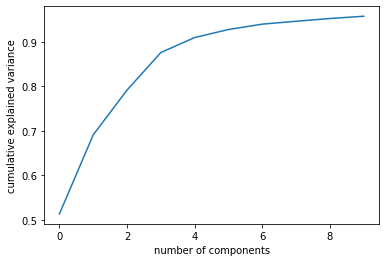

In [11]:
# TODO: check representational power of PCA features

dataset.pca(n_components=10, verbose=True)
np.sum(dataset.pca_.explained_variance_ratio_)

In [12]:
pca_importance(dataset)

,pc,feature
0,pc-1,X7SK.4
1,pc-2,MT.RNR2
2,pc-3,MALAT1
3,pc-4,RN7SL2
4,pc-5,NEFL
5,pc-6,COL3A1
6,pc-7,MAP1B
7,pc-8,COL3A1
8,pc-9,EEF2
9,pc-10,SNORD3C
